In [13]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
num_epochs = 100
batch_size = 32
learning_rate = 0.001

train_dir = r'../input/animals-classification/Classification (Train_Val)/Train'
test_dir = r'../input/animals-classification/Classification (Train_Val)/Val'

In [16]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transF.pad(image, padding, 0, 'constant')

In [17]:
train_transforms = transforms.Compose([
                                       SquarePad(),
                                       transforms.Resize((330, 330)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.3909, 0.3764, 0.3076],
                                                            [0.3262, 0.3165, 0.3023])])

test_transforms = transforms.Compose([SquarePad(),
                                      transforms.Resize((330, 330)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.3909, 0.3764, 0.3076],
                                                           [0.3262, 0.3165, 0.3023])])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

368 74


In [18]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = [0.5199, 0.5007, 0.4075], std = [0.2689, 0.2625, 0.2789])

torch.Size([32, 3, 330, 330]) torch.Size([32])


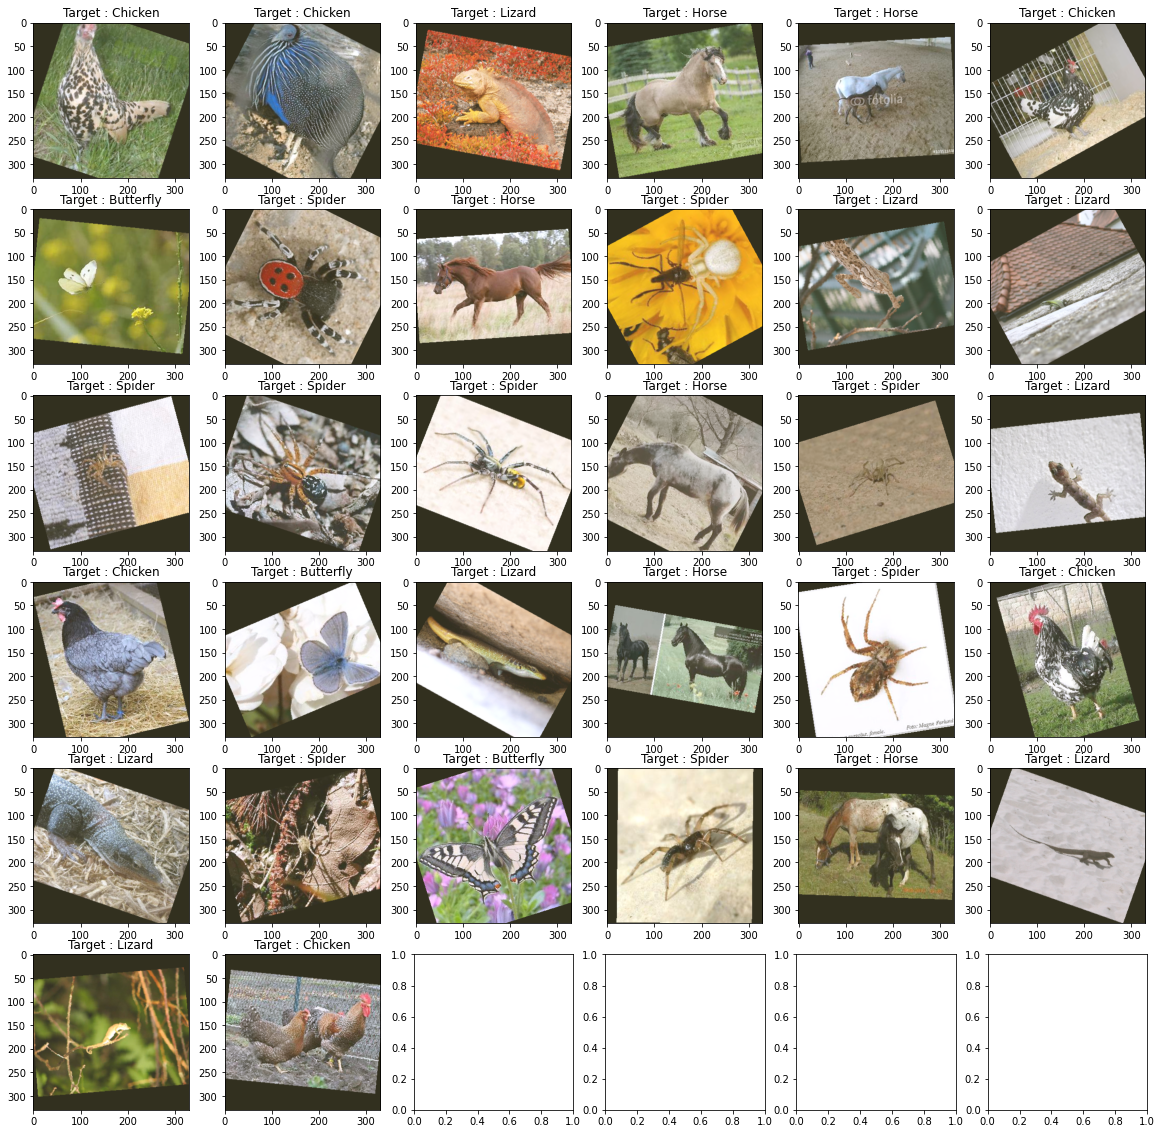

In [19]:
target_names = ['Butterfly', 'Chicken', 'Horse', 'Lizard', 'Spider']
images,labels = next(iter(train_loader))
print(images.shape, labels.shape)
plt.subplots(6,6 , figsize=(20,20))
for i, (image, label) in enumerate(zip(images,labels)):
    plt.subplot(6, 6, i+1)
    temp = image.detach().clone()
    temp = unorm(temp)
    plt.imshow( temp.permute(1, 2, 0))
    plt.title("Target : " + target_names[label.numpy()])
plt.show()

In [20]:
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(512, 5))

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def train(model, train_loader):
    model.train()
    train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # accuracy
        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_train += (labels == predicted).sum().item()
        train_acc = (100 * correct_train) / target_count
    return train_acc, train_loss / target_count

In [23]:
def validate(model,val_loader):
    model.eval()
    val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_val += (labels == predicted).sum().item()
        val_acc = (100 * correct_val) / target_count
    return val_acc, val_loss / target_count 

In [24]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

# Early stopping
the_last_loss = 100
patience = 10
trigger_times = 0
isStopped = False

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

for epoch in range(0, num_epochs):
    
    train_acc, train_loss = train(model, train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    val_acc,val_loss = validate(model, test_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    print("Epoch {0}: train_acc {1} \t train_loss {2} \t val_acc {3} \t val_loss {4}".format(epoch, train_acc, train_loss, val_acc, val_loss))
    
    the_current_loss = val_loss
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times: ', trigger_times)
        if trigger_times >= patience:
            print('Early stopping! at epoch {0}'.format(epoch))
            isStopped = True
            break
    else:
        print('trigger times: 0')
        trigger_times = 0
        the_last_loss = the_current_loss
        if not isStopped:
            torch.save(model.state_dict(), 'mymodel_pretrain.pt')
            print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

Epoch 0: train_acc 81.15178798946742 	 train_loss 0.017101444907731352 	 val_acc 76.24946604015378 	 val_loss 0.024570181018442938
trigger times: 0
Validation loss 0.024570.  Saving model ...
Epoch 1: train_acc 88.05741951923893 	 train_loss 0.01121248105115436 	 val_acc 91.96924391285775 	 val_loss 0.006720640699767827
trigger times: 0
Validation loss 0.006721.  Saving model ...
Epoch 2: train_acc 90.30833262549902 	 train_loss 0.008870367298074682 	 val_acc 89.79068774028192 	 val_loss 0.009187238276186203
trigger times:  1
Epoch 3: train_acc 91.88821880574196 	 train_loss 0.007600830757928302 	 val_acc 90.04698846646733 	 val_loss 0.009375353625051387
trigger times:  2
Epoch 4: train_acc 92.15153316911578 	 train_loss 0.007268689616161571 	 val_acc 93.84878257155061 	 val_loss 0.00557229496138421
trigger times: 0
Validation loss 0.005572.  Saving model ...
Epoch 5: train_acc 93.65497324386308 	 train_loss 0.006172565555053317 	 val_acc 89.74797095258437 	 val_loss 0.0084726822798031

In [25]:
model.load_state_dict(torch.load('mymodel_pretrain.pt'))

<All keys matched successfully>

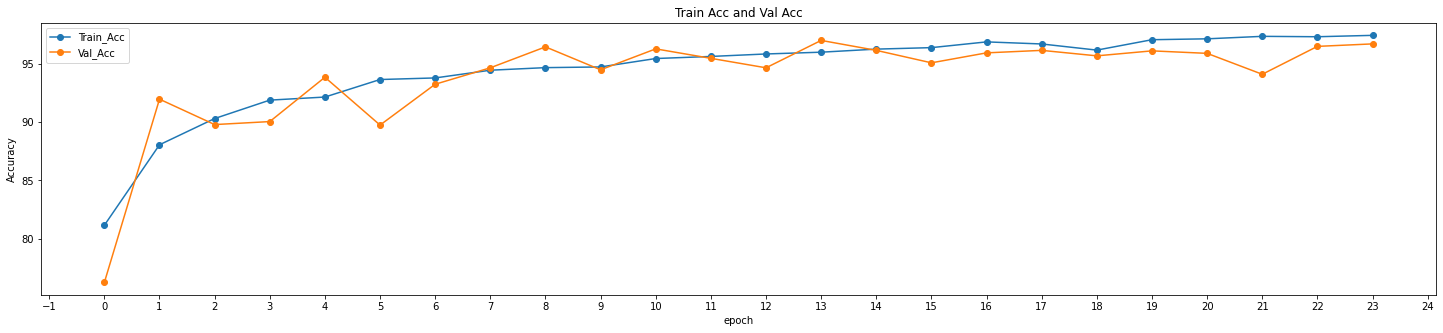

In [26]:
plt.figure(figsize=(25,5))
plt.plot(train_acc_history,'-o')
plt.plot(val_acc_history,'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Acc','Val_Acc'])
plt.title('Train Acc and Val Acc')
plt.show()

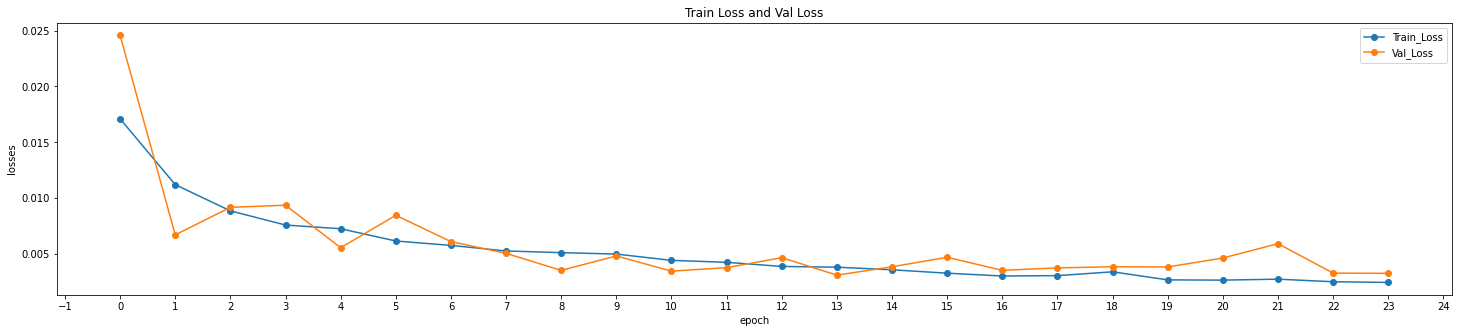

In [27]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Loss','Val_Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [28]:
model.eval()
pred_list = []
label_list = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    running_loss=0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)
        pred_list.extend(predictions.cpu().numpy())
        label_list.extend(labels.cpu().numpy())
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 97.00982486117044 %


In [29]:
from sklearn.metrics import confusion_matrix
cm_percentage=confusion_matrix(label_list,pred_list, normalize='true')
cm_number=confusion_matrix(label_list,pred_list)

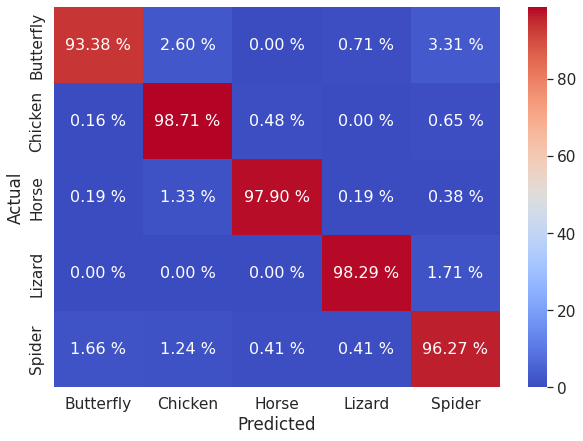

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

target_names = ['Butterfly', 'Chicken', 'Horse', 'Lizard', 'Spider']
df_cm = pd.DataFrame(cm_percentage*100, range(5), range(5))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True,cmap='coolwarm', annot_kws={"size": 16}, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

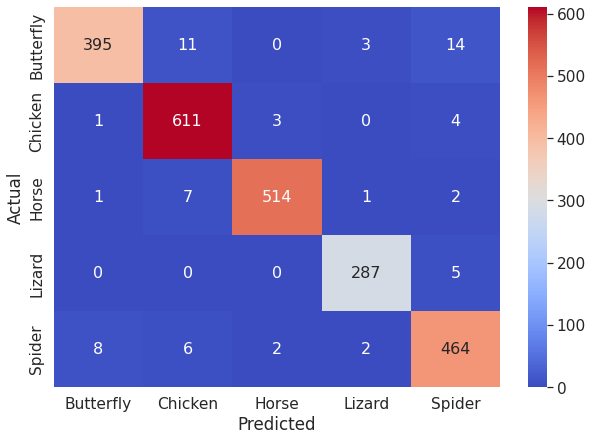

In [31]:
cm_number = cm_number.astype(int)
df_cm = pd.DataFrame(cm_number, range(5), range(5))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 16}, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)